## Data import

Note:
- cadCAD library designed for simulations of complex systems has been used to backtest the Stoikov's strategy. 
- I took the first 10000 rows from df_book and the first 35000 rows from df_trades due to limitations of computer power
- The delay parameter impacting the delay between placing new two-sided trades has been set 
to 1000000000 (1 second) due to the fact that it has accelerated the computations
- Other parameters have been kept how they were in the article. However, design of these parameters can improve the performance of the strategy


In [2]:
import os

os.chdir("/Users/slitasov/PycharmProjects/pythonCmf/venv")

In [3]:
from initial_state import *
from policy_functions import *
from state_variables import *

In [4]:
x = pd.to_datetime(df_book['timestamp'])

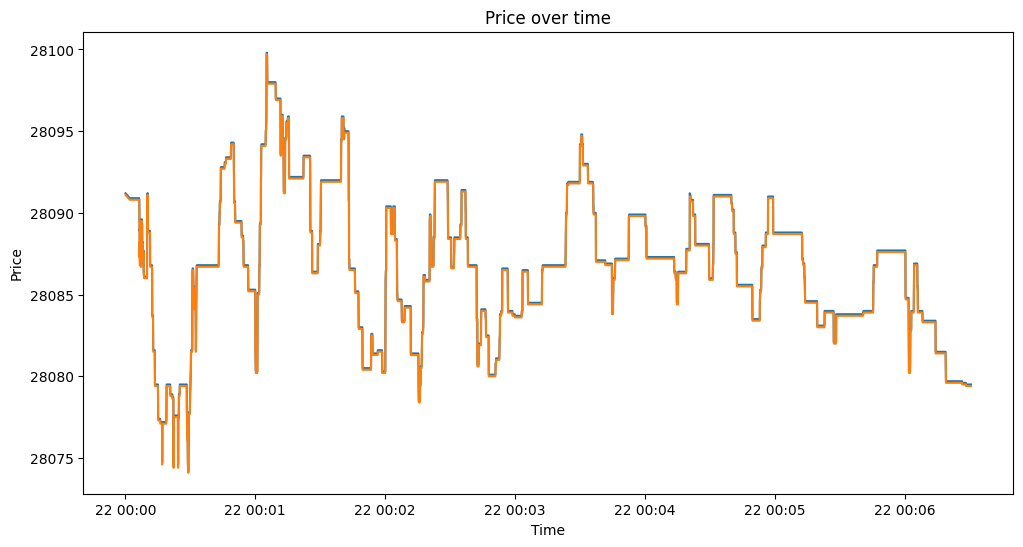

In [5]:
plt.figure(figsize=(12,6))
plt.plot(x, df_book['asks[0].price'])
plt.plot(x, df_book['bids[0].price'])
plt.title('Price over time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [6]:
df_book['spread'] = df_book['asks[0].price'] - df_book['bids[0].price']
df_book['spread'].describe()

count    10000.000000
mean         0.103970
std          0.072248
min          0.100000
25%          0.100000
50%          0.100000
75%          0.100000
max          2.300000
Name: spread, dtype: float64

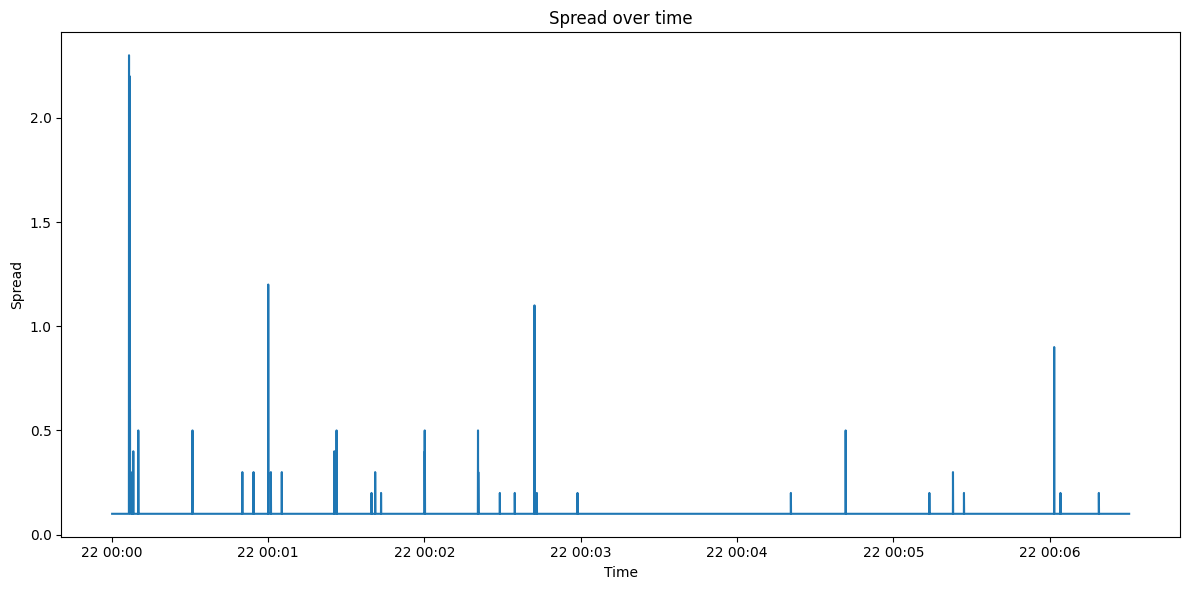

In [7]:
plt.figure(figsize=(12,6))

plt.title('Spread over time')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.plot(x, df_book['spread'])

plt.tight_layout()
plt.show()


In [8]:
# Function to calculate the first n elements in columns 'asks[i].price'
def calculate_bid_depth(row, n):
    return sum(row[f'asks[{i-1}].price'] * row[f'asks[{i-1}].amount'] for i in range(1, n + 1))

def calculate_ask_depth(row, n):
    return sum(row[f'bids[{i-1}].price'] * row[f'bids[{i-1}].amount'] for i in range(1, n + 1))

for n in range(1, 11):
    df_book[f'bid_depth{n-1}'] = df_book.apply(lambda row: calculate_bid_depth(row, n), axis=1)
    df_book[f'ask_depth{n-1}'] = df_book.apply(lambda row: calculate_ask_depth(row, n), axis=1)

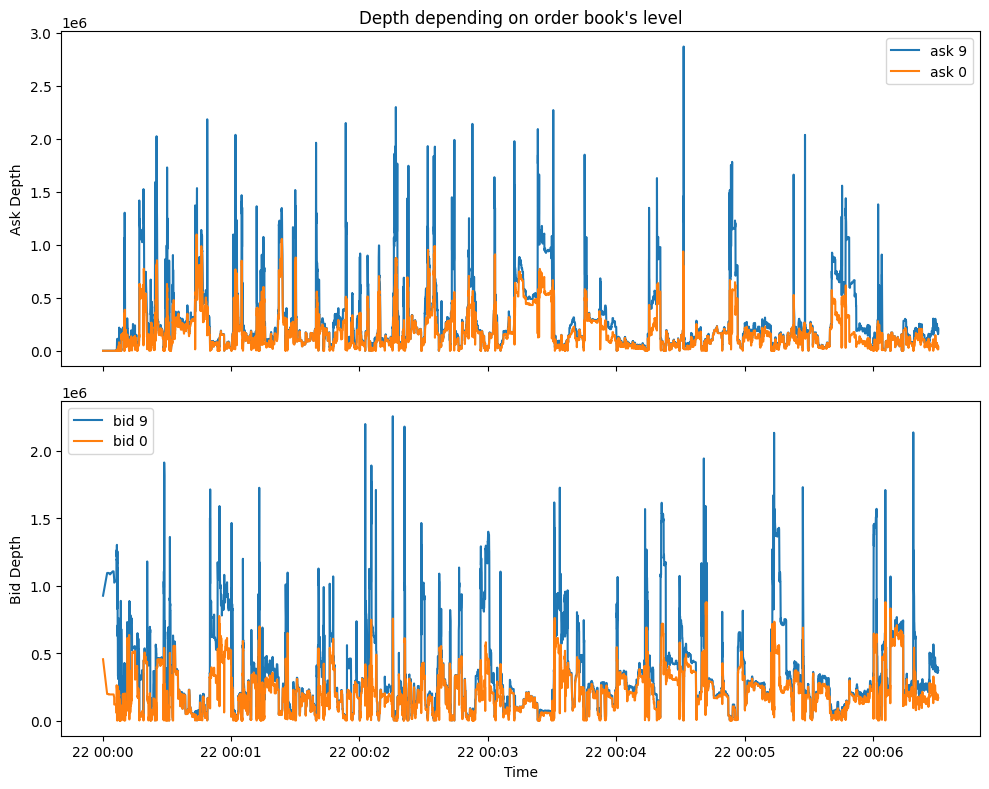

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

# Plot for asks
ax[0].plot(x, df_book[f'ask_depth9'], label='ask 9')
ax[0].plot(x, df_book[f'ask_depth0'], label='ask 0')
ax[0].set_ylabel('Ask Depth')
ax[0].legend()
ax[0].set_title('Depth depending on order book\'s level')

# Plot for bids
ax[1].plot(x, df_book[f'bid_depth9'], label='bid 9')
ax[1].plot(x, df_book[f'bid_depth0'], label='bid 0')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Bid Depth')
ax[1].legend()

plt.tight_layout()
plt.show()


In [10]:
df_book.drop(columns=['exchange', 'symbol'], inplace=True)

In [11]:
# Depth of order's size
df_depth = df_book.copy()
for i in range(1, 25): 
    size_sum_ask = 0
    size_sum_bids = 0

    for q in range(i+1):
        
        size_sum_ask += df_book[f'asks[{q}].amount']
        size_sum_bids += df_book[f'bids[{q}].amount']
        
    df_depth[f'asks[{i}].amount'] = size_sum_ask 
    df_depth[f'bids[{i}].amount'] = size_sum_bids

df_book = df_depth

## Simulation (Stoikov's strategy)

High level overview: 

1. Place orders
- Take the current state on an Order Book. Calculate reservation prices and other parameters related to placing an order. 
- If (current_time - previous_order_place_time) > delay --> place an order and add it to active_orders

2. Removing orders
- Remove orders in active_orders that are held > hold_time
- For each trade that have been executed between previous state of the OB and current state of the OB check if the size of the order is higher than the depth of each of the active orders. If the size is higher --> execute an order and remove it from active_orders, keep the order otherwise
- Make a final trade to set q equal to 0 and calculate PnL

In [12]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=experiment.configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 9999, 11, 1, 11)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (9999, 11, 1, 11)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 549.69s


In [13]:
df = pd.DataFrame(raw_result)

In [14]:
df = df[df['substep'] == 3]

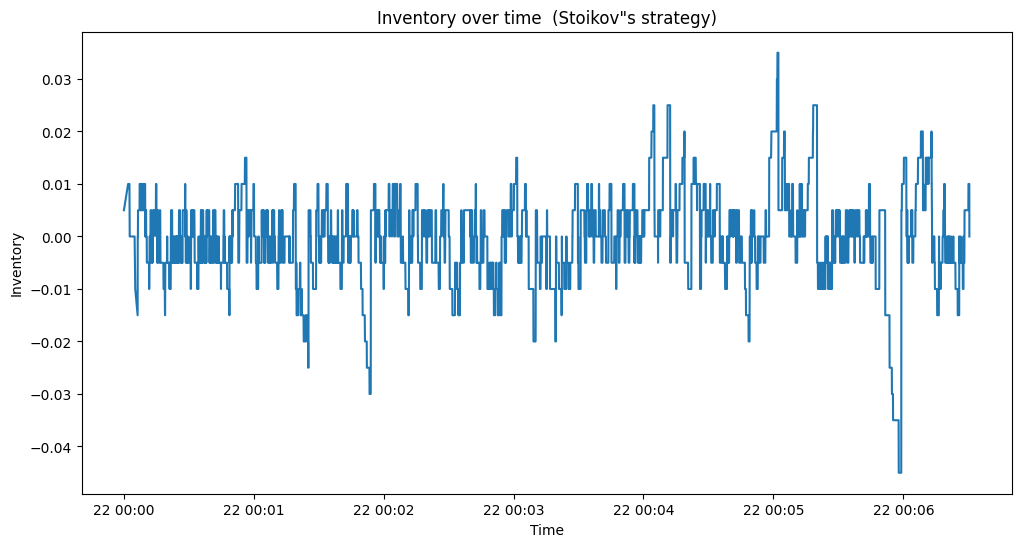

In [15]:
x = x[:len(df_book) - 1]

plt.figure(figsize=(12,6))
plt.title('Inventory over time  (Stoikov"s strategy)')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.plot(x[:], df['q'])
plt.show()

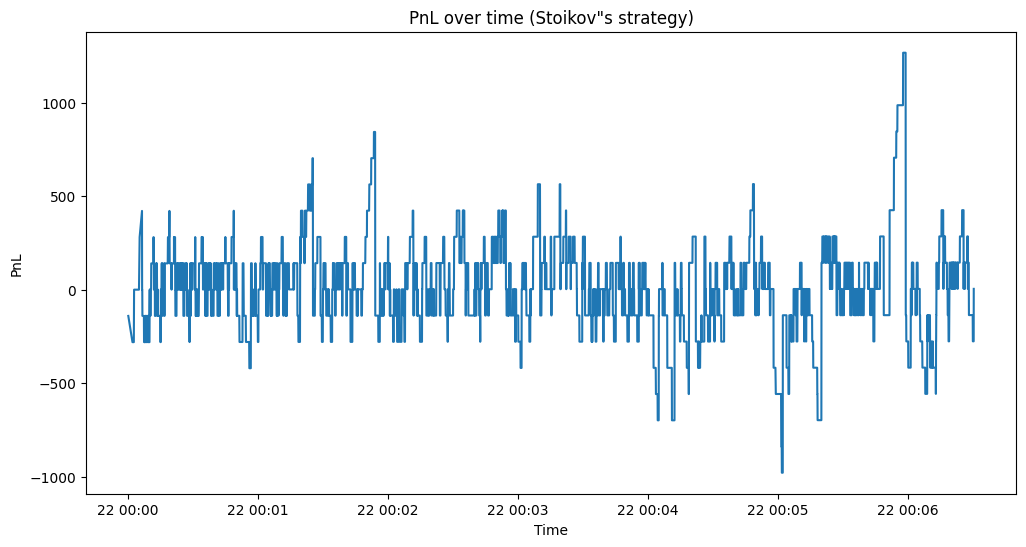

In [16]:
plt.figure(figsize=(12,6))

plt.title('PnL over time (Stoikov"s strategy)')
plt.xlabel('Time')
plt.ylabel('PnL')
plt.plot(x, df['PnL'])
plt.show()

In [17]:
print('Final PnL of basic  strategy:', '$' + str(df['PnL'].iloc[-1]))

Final PnL of basic  strategy: $4.348667105410129


## Simulation (Stoikov's strategy with volatility imlabace applied)

Strategy's Enhancement

To enhance Stoikov market's algorithm I decided to manage sizes with volatility imlabace

Since Stoikov's strategy is to place two-sided orders and earn on spreads, I decided to manage bid/ask sized based on volatility imbalance

$$p = \frac{v_b - v_a}{v_b + v_a}$$

1.For 'bid' orders

if p > 0:
   p = min(0.85 + p, 1)
else:
   p = min(1.85 - p, 1)

2.For 'ask' orders 

if p < 0:
   p = min(0.85 + abs(p), 1)
else:
   p = min(1.85 - abs(p), 1)

In [18]:
from initial_state import *
from policy_functions_volume_enhanced import *
from state_variables_volume_enhanced import *

In [19]:
del configs[:]

In [20]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=experiment.configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 9999, 11, 1, 11)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (9999, 11, 1, 11)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 554.22s


In [21]:
df = pd.DataFrame(raw_result)
df = df[df['substep'] == 3]

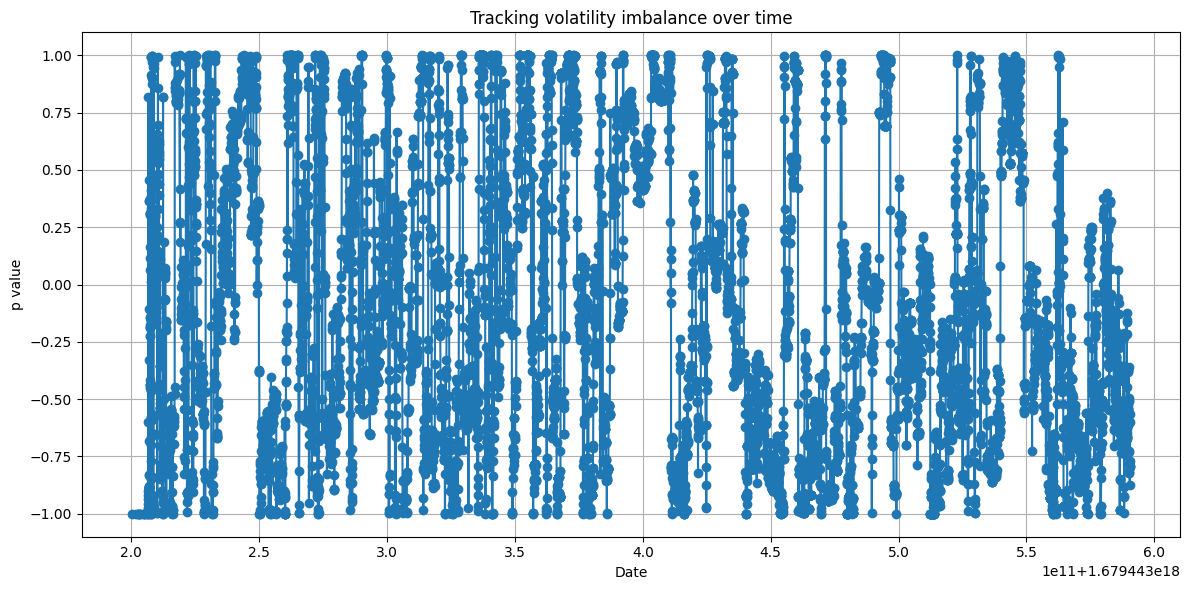

In [27]:
# Calculate p for each row
def calculate_p(row):
    v_a = row['asks[0].amount']
    v_b = row['bids[0].amount']
    return (v_b - v_a) / (v_b + v_a)

df_book['p'] = df_book.apply(calculate_p, axis=1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_book['timestamp'], df_book['p'], marker='o')
plt.xlabel('Date')
plt.ylabel('p value')
plt.title('Tracking volatility imbalance over time')
plt.grid(True)
plt.tight_layout()
plt.show()

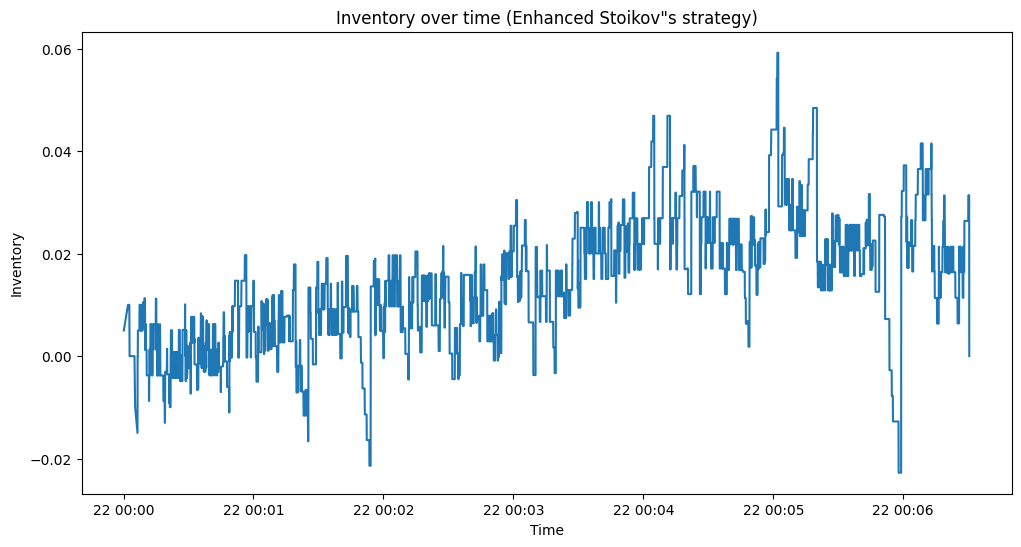

In [23]:
x = x[:len(df_book) - 1]

plt.figure(figsize=(12,6))
plt.title('Inventory over time (Enhanced Stoikov"s strategy)')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.plot(x[:], df['q'])
plt.show()

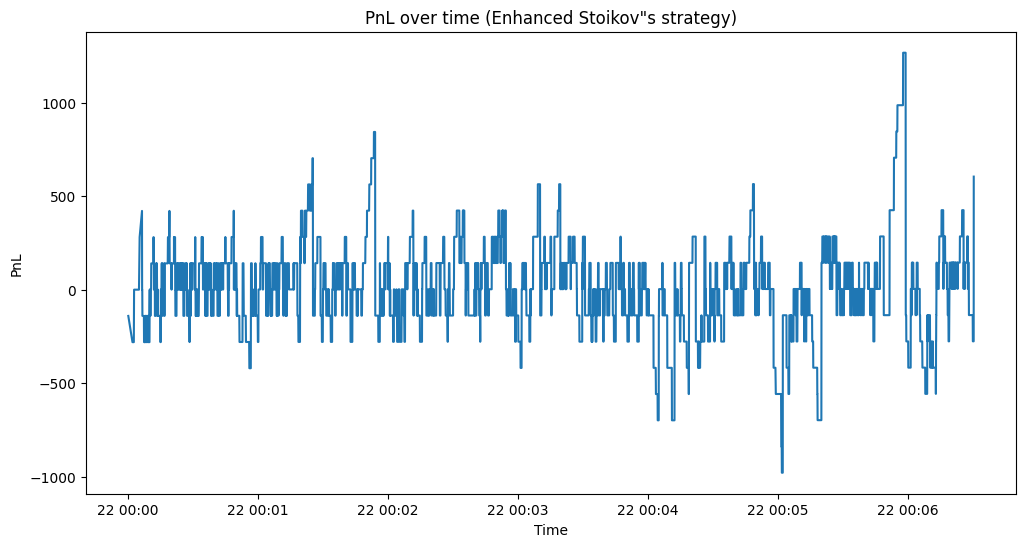

In [24]:
plt.figure(figsize=(12,6))

plt.title('PnL over time (Enhanced Stoikov"s strategy)')
plt.xlabel('Time')
plt.ylabel('PnL')
plt.plot(x, df['PnL'])
plt.show()

In [25]:
print('Final PnL of Enhanced strategy:', '$' + str(df['PnL'].iloc[-1]))

Final PnL of Enhanced strategy: $605.0201316034161


##  Models comparison

Thus, the enhancement of the model led to positive results. This approach helped to increase the PnL from 4 USD to 605 USD being an important parameter in the model's design